In [1]:
import os

import PIL
from PIL import Image
import numpy as np
import pandas as pd
import json
from collections import defaultdict
from tqdm.auto import tqdm

import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import UniPCMultistepScheduler


/home/slava/.conda/envs/algonauts/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_img(img_path):
    image = Image.open(img_path).convert("RGB")
    w, h = 512, 512
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.
    
subj = 1
img_name = 'train-0001_nsd-00013.png'
img_path = os.path.join(
    "/SSD/slava/algonauts/algonauts_2023_challenge_data/",
    f"subj0{subj}/training_split/training_images/",
    img_name
)

sample_img = load_img(img_path)
sample_img.shape

torch.Size([1, 3, 512, 512])

In [3]:
nsd_stiminfo_file = '/SSD/slava/algonauts/algonauts_2023_challenge_data/nsd_stim_info_merged.pkl'
stiminfo = pd.read_pickle(nsd_stiminfo_file)
cocoId = np.array(stiminfo['cocoId'])

annotations = "/SSD/slava/algonauts/algonauts_2023_challenge_data/annotations/captions_train2017.json"
dataset = json.load(open(annotations, 'r'))

imgIdToAnns = defaultdict(list)

if 'annotations' in dataset:
    for ann in dataset['annotations']:
        imgIdToAnns[ann['image_id']].append(ann)

annotation_val = "/SSD/slava/algonauts/algonauts_2023_challenge_data/annotations/captions_val2017.json"
dataset = dict()
dataset = json.load(open(annotation_val, 'r'))

if 'annotations' in dataset:
    for ann in dataset['annotations']:
        imgIdToAnns[ann['image_id']].append(ann)


In [4]:
nsd_id = img_name.split("-")[-1].replace(".png", "")
coco_id = cocoId[int(nsd_id)]

captions = imgIdToAnns[coco_id]
captions = [x['caption'] for x in captions]
len(captions), captions[0]

(5, 'A disorderly living area is free from decorative elements.')

# Stable Diffusion 

In [5]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

torch_device = "cuda:0"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

print()

In [6]:
prompt = ["a photograph of an astronaut riding a horse"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 50  # Number of denoising steps
guidance_scale = 5.0  # Scale for classifier-free guidance
strength = 0.8
batch_size = 1

# Setting number of steps in scheduler
scheduler.set_timesteps(num_inference_steps)

In [7]:
text_input = tokenizer(
    captions, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# take average of 5 captions
text_embeddings = text_embeddings.mean(0).unsqueeze(0)
text_embeddings.shape

torch.Size([1, 77, 768])

In [8]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
text_embeddings.shape

torch.Size([2, 77, 768])

In [9]:
(batch_size, unet.in_channels, height // 8, width // 8)

/tmp/ipykernel_24161/2354355430.py:1: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8)


(1, 4, 64, 64)

In [10]:
init_latents = vae.encode(sample_img.to(torch_device)).latent_dist.sample()* 0.18215

In [11]:
init_timestep = int(num_inference_steps * strength) 
timesteps = scheduler.timesteps[-init_timestep]
timesteps = torch.tensor([timesteps], device=torch_device).long()

In [12]:
# Adding noise to the latents 
noise = torch.randn(init_latents.shape, generator=None, device=torch_device, dtype=init_latents.dtype)
init_latents = scheduler.add_noise(init_latents, noise, timesteps)
latents = init_latents

# Computing the timestep to start the diffusion loop
t_start = max(num_inference_steps - init_timestep, 0)
timesteps = scheduler.timesteps[t_start:].to(torch_device).long()

init_timestep, timesteps[0]

(40, tensor(799, device='cuda:0'))

In [13]:
# Iterating through defined steps
for i,ts in enumerate(tqdm(timesteps)):
    # We need to scale the i/p latents to match the variance
    inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
    
    # Predicting noise residual using U-Net
    with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=text_embeddings).sample.chunk(2)
        
    # Performing Guidance
    pred = u + guidance_scale*(t-u)
    
    # Conditioning  the latents
    latents = scheduler.step(pred, ts, latents).prev_sample

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:12<00:00,  3.13it/s]


In [14]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

print("Init latents: ", init_latents.shape)
print("Last Latents: ", latents.shape)

with torch.no_grad():
    image = vae.decode(latents).sample

Init latents:  torch.Size([1, 4, 64, 64])
Last Latents:  torch.Size([1, 4, 64, 64])


In [15]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
image.shape

(1, 512, 512, 3)

# Image from Stable Diffusion

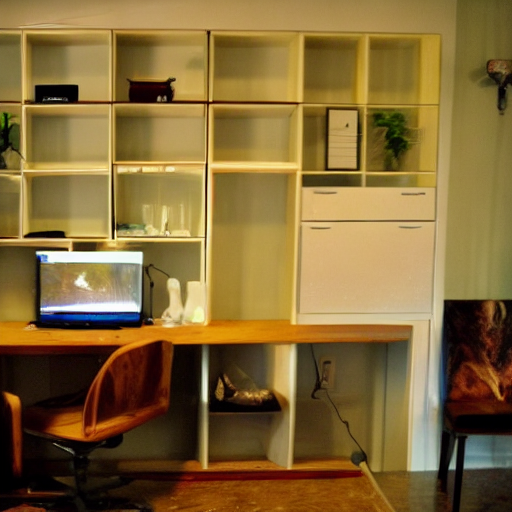

In [16]:
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

# Original Images

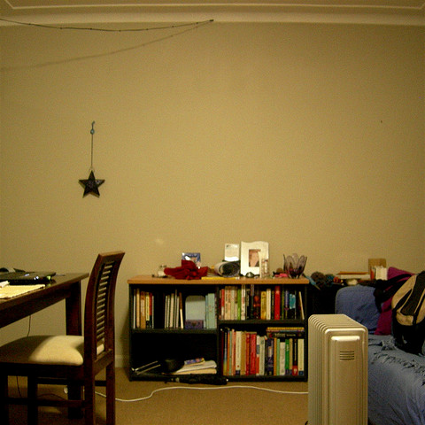

In [17]:
Image.open(img_path)